# Projet Deep Learning : Faster-RCNN pour la détection et reconnaissance de chiffres dans des images
On souhaite réaliser la reconnaissance de séquences de chiffres manuscrits pouvant se superposer.
La reconnaissance de ces séquences de chiffres sera réalisée à l’aide d’un réseau de type Faster-RCNN.
Réalisé par : Othmane Nabgouri

# Partie 1 : Génération des données
Tout d'abord, on a bseoin d'un ensemble de données qui contiennent des images avec les objets qu'on souhaite détecter. Ces images sont des séquence de chiffres et les labels seront les chiffres correspondant à la séquence.

11490434/11490434 [==============================] - 0s 0us/step
donne pour entrainement: 12000
donne pour test:  2000
Taille train 5 digits 12000
Taille test 5 digits 2000


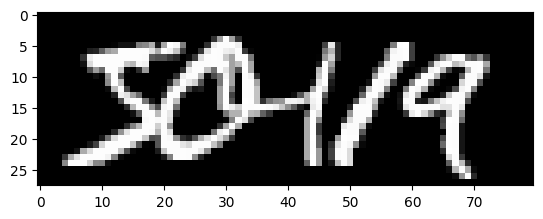

[5 0 4 1 9]


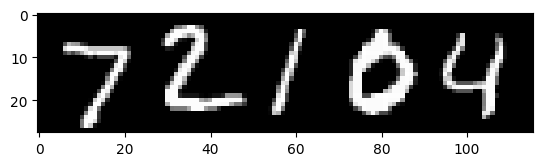

[7 2 1 0 4]


In [1]:
# -*- coding: utf-8 -*-

import numpy as np
from mlxtend.data import loadlocal_mnist
from keras.datasets import mnist
import matplotlib.pyplot as plt
import random
import pickle
import sys
np.set_printoptions(threshold=sys.maxsize)



def generate_seq(x_data, y_label, Nb_seq, l_seq):

    X_data = []
    Y_label = []
    list_des_recouv = np.zeros(Nb_seq)
    for k in range(Nb_seq):
        recouvrement = random.randint(5, 15) # Espace entre les séquences
        list_des_recouv[k]=recouvrement

        image = np.zeros((x_data[k*l_seq].shape[0], l_seq*x_data[k*l_seq].shape[0] - (l_seq-1)*recouvrement))
        seq_label = np.ones(l_seq, dtype='int')
        seq_label[0] = y_label[k * l_seq]
        image[:, 0:D]=x_data[k * l_seq]
        for n in range(1, l_seq):
            image[:, n * (D - recouvrement):n * (D - recouvrement) + D] = np.maximum(image[:, n * (D - recouvrement):n * (D - recouvrement)+D],
                                                                                     x_data[k * l_seq + n])
            seq_label[n] = y_label[k * l_seq + n]
            
        X_data.append(image)
        Y_label.append(seq_label)

    return [X_data, Y_label,list_des_recouv]

###############################################################################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Taille_train = x_train.shape[0]
Taille_test = x_test.shape[0]

###############################################################################
# longueur des sequences de digits
l_seq_digits = 5
D = 28
labels = np.unique(y_train)
Nb_seq_train = int(Taille_train / l_seq_digits)
Nb_seq_test = int(Taille_test / l_seq_digits)

print("donne pour entrainement: " + str(Nb_seq_train))
print(f'donne pour test:  {Nb_seq_test}')
print("Taille train 5 digits", Nb_seq_train)
print("Taille test 5 digits", Nb_seq_test)


#################################################
X_train_seq, y_train_seq,List_recou_train = generate_seq(x_train, y_train, Nb_seq_train, l_seq_digits)  # Set d'entrainement
plt.imshow(X_train_seq[0], cmap='gray')
plt.show()
print(y_train_seq[0])

X_test_seq, y_test_seq,List_recou_test = generate_seq(x_test, y_test, Nb_seq_test, l_seq_digits) # Set de test
plt.imshow(X_test_seq[0], cmap='gray')
plt.show()
print(y_test_seq[0])


# Partie 2 : COCO FORMAT
Ensuite, il faut préparer les données pour l'entraînement. Cela peut inclure la conversion des annotations dans un format compatible avec Detectron 2 qui est le format COCO.
Dans cette partie on :
- Crée des répertoires ou on eregistre les données
- Crée des dictionnaires COCO
- Crée les fichier JSON à partir des dictionnaire COCO

In [2]:
import os
import json 

# Créer des répertoires pour les images et les annotations 
if not os.path.exists('Train_x'):
    os.makedirs('Train_x')
if not os.path.exists('Train_y'):
    os.makedirs('Train_y')

# Boucle qui parcoure les images et les enregistres avec les annotations correspondantes
for i, (img, label) in enumerate(zip(X_train_seq, y_train_seq)):
    img_filename = f'image_{i}.png'
    img_filepath = os.path.join('Train_x', img_filename)
    plt.imsave(img_filepath, img, cmap='gray')
    
    label_filename = f'label_{i}.txt'
    label_filepath = os.path.join('Train_y', label_filename)
    with open(label_filepath, 'w') as f:
        f.write(' '.join(map(str, label)))

# Creation du dictionnaire de format COCO
coco_dict = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Définir les categories/Labels
coco_dict["categories"]=[]
coco_dict["categories"].append({"id":"0","name":"zero"})
coco_dict["categories"].append({"id":"1","name":"one"})
coco_dict["categories"].append({"id":"2","name":"two"})
coco_dict["categories"].append({"id":"3","name":"three"})
coco_dict["categories"].append({"id":"4","name":"four"})
coco_dict["categories"].append({"id":"5","name":"five"})
coco_dict["categories"].append({"id":"6","name":"six"})
coco_dict["categories"].append({"id":"7","name":"seven"})
coco_dict["categories"].append({"id":"8","name":"eight"})
coco_dict["categories"].append({"id":"9","name":"nine"})


# Parcour des images et leurs labels
for i, (img, label) in enumerate(zip(X_train_seq, y_train_seq)):
    # On Ajoute les informations des images au dictionnaire COCO
    img_filename = f'image_{i}.png'
    img_filepath = os.path.join('Train_x', img_filename)
    img_id = i
    img_info = {
        'id': img_id,
        'width': img.shape[1],
        'height': img.shape[0],
        'file_name': img_filepath
    }
    coco_dict['images'].append(img_info)

    # On Ajoute les informations d'annotation au dictionnaire COCO
    for j in range(l_seq_digits):
        ann_id = i*l_seq_digits + j
        ann_info = {
            'id': ann_id,
            'image_id': img_id,
            'category_id': str(label[j]), #category['id'],
            'segmentation': [],
            'area': img.shape[0]*img.shape[1],
            'bbox': [j*(D-List_recou_train[i]), 0, 28, 28],
            'iscrowd': 0,
            'attributes': {},        
        }
        coco_dict['annotations'].append(ann_info)

# Enregistrement du disctionnare COCO sous forme d'un fichier JSON
with open('coco_train.json', 'w') as f:
    json.dump(coco_dict, f,default=str) 


In [3]:
# On suit les memes étapes pour les données de Test

if not os.path.exists('Test_x'):
    os.makedirs('Test_x')
if not os.path.exists('Test_y'):
    os.makedirs('Test_y')

for i, (img, label) in enumerate(zip(X_test_seq, y_test_seq)):
    img_filename = f'image_{i}.png'
    img_filepath = os.path.join('Test_x', img_filename)
    plt.imsave(img_filepath, img, cmap='gray')
    
    label_filename = f'label_{i}.txt'
    label_filepath = os.path.join('Test_y', label_filename)
    with open(label_filepath, 'w') as f:
        f.write(' '.join(map(str, label)))


coco_dict = {
    "images": [],
    "annotations": [],
    "categories": []
}

coco_dict["categories"]=[]
coco_dict["categories"].append({"id":"0","name":"zero"})
coco_dict["categories"].append({"id":"1","name":"one"})
coco_dict["categories"].append({"id":"2","name":"two"})
coco_dict["categories"].append({"id":"3","name":"three"})
coco_dict["categories"].append({"id":"4","name":"four"})
coco_dict["categories"].append({"id":"5","name":"five"})
coco_dict["categories"].append({"id":"6","name":"six"})
coco_dict["categories"].append({"id":"7","name":"seven"})
coco_dict["categories"].append({"id":"8","name":"eight"})
coco_dict["categories"].append({"id":"9","name":"nine"})


for i, (img, label) in enumerate(zip(X_test_seq, y_test_seq)):
    img_filename = f'image_{i}.png'
    img_filepath = os.path.join('Test_x', img_filename)
    img_id = i
    img_info = {
        'id': img_id,
        'width': img.shape[1],
        'height': img.shape[0],
        'file_name': img_filepath
    }
    coco_dict['images'].append(img_info)

    for j in range(l_seq_digits):
        ann_id = i*l_seq_digits + j
        ann_info = {
            'id': ann_id,
            'image_id': img_id,
            'category_id': str(label[j]),
            'segmentation': [],
            'area': img.shape[0]*img.shape[1],
            'bbox': [j*(D-List_recou_test[i]), 0, 28, 28],
            'iscrowd': 0,
            'attributes': {},    
        }
        coco_dict['annotations'].append(ann_info)


with open('coco_test.json', 'w') as f:
    json.dump(coco_dict, f,default=str) 


# Partie 3 : Modele training :
Il faut ensuite configurer le modèle Faster R-CNN (définir les hyperparamètres du modèle :le nombre de couches, la taille du noyau, le taux d'apprentissage, le nombre d'itérations...). Une fois que les données et le modèle ont été configurés, il est temps de commencer l'entraînement du modèle.


In [4]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=44f2f56201ff638b8aa1e6df5f142099c5121f8239804789197e36b8fe68ce8b
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [5]:
#!pip install pyyaml==5.1
#!pip install  detectron2
import torch
import cv2
from detectron2.utils.colormap import random_color

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
from google.colab.patches import cv2_imshow

from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

## Préparation des données
# On enregistre les données de test en format coco

for data_type in ["train","test"]: 
    reg_name=f"mnist_detection_{data_type}"
    register_coco_instances(reg_name, {}, f"coco_{data_type}.json", "")

mnist_detection_metadata = MetadataCatalog.get(reg_name)
dataset_dicts = DatasetCatalog.get(reg_name)

torch:  2.0 ; cuda:  cu118


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Test_x/image_152.png


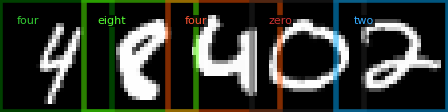

Test_x/image_997.png


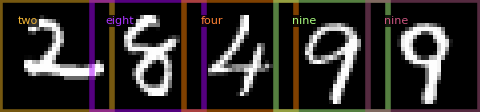

Test_x/image_1612.png


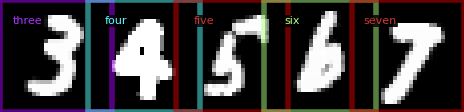

Test_x/image_851.png


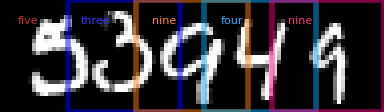

Test_x/image_1699.png


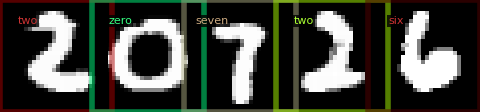

Test_x/image_309.png


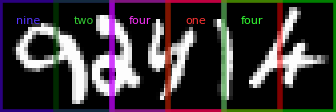

Test_x/image_995.png


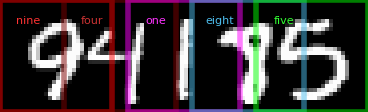

Test_x/image_1022.png


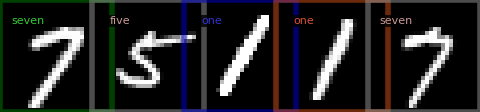

Test_x/image_996.png


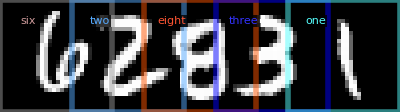

Test_x/image_1498.png


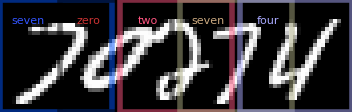

In [6]:
# Visualisation des résultats
for d in random.sample(dataset_dicts, 10):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=4.0)
    
    # On écrit le label et on dessine le contour pour chaque chiffre
    for obj in d["annotations"]:
        bbox = obj["bbox"]
        label = mnist_detection_metadata.thing_classes[obj["category_id"]]
        x_center = bbox[0] + bbox[2] / 4
        y_center = bbox[1] + bbox[3] / 7
        bbox_draw = [bbox[0], 0, bbox[0] + bbox[2], bbox[3] ]
        color = random_color(rgb=True, maximum=1)
        vis = visualizer.draw_box(bbox_draw, edge_color=color, alpha=0.5)
        vis = visualizer.draw_text(label, (x_center, y_center),color=color)
      
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances


## Entraînement du modèle
# On utilise la configuration du modèle faster_rcnn_R_50_FPN_3x.yaml pour entraîner le modèle
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# On utilise les données d'entraînement enregistrées précédemment
cfg.DATASETS.TRAIN = ("mnist_detection_train",) 
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# On utilise les poids pré-entraînés pour le modèle faster_rcnn_R_50_FPN_3x
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004
cfg.SOLVER.MAX_ITER = (1000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
# On crée le dossier de sortie si il n'existe pas
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# On crée un entraîneur avec la configuration définie ci-dessus
trainer = DefaultTrainer(cfg)
# On commence l'entraînement
trainer.resume_or_load(resume=False)
dictionnary=trainer.train()

torch:  2.0 ; cuda:  cu118
[04/10 23:29:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

model_final_280758.pkl: 167MB [00:01, 87.5MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/10 23:29:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/10 23:29:21 d2.utils.events]:  eta: 0:06:12  iter: 19  total_loss: 3.58  loss_cls: 2.418  loss_box_reg: 1.005  loss_rpn_cls: 0.09293  loss_rpn_loc: 0.06913    time: 0.3733  last_time: 0.3377  data_time: 0.0373  last_data_time: 0.0370   lr: 7.9924e-06  max_mem: 1745M
[04/10 23:29:27 d2.utils.events]:  eta: 0:05:17  iter: 39  total_loss: 3.266  loss_cls: 2.176  loss_box_reg: 1.012  loss_rpn_cls: 0.04007  loss_rpn_loc: 0.03879    time: 0.3469  last_time: 0.2988  data_time: 0.0152  last_data_time: 0.0142   lr: 1.5984e-05  max_mem: 1745M
[04/10 23:29:33 d2.utils.events]:  eta: 0:04:50  iter: 59  total_loss: 2.667  loss_cls: 1.597  loss_box_reg: 1.012  loss_rpn_cls: 0.02211  loss_rpn_loc: 0.04016    time: 0.3285  last_time: 0.3327  data_time: 0.0080  last_data_time: 0.0203   lr: 2.3976e-05  max_mem: 1746M
[04/10 23:29:39 d2.utils.events]:  eta: 0:04:49  iter: 79  total_loss: 2.171  loss_cls: 1.079  loss_box_reg: 1.042  loss_rpn_cls: 0.01984  loss_rpn_loc: 0.0389    time: 0.3233  last_tim

# Partie 4 : Model Evaluation
Après l'entraînement, il faut évaluer les performances du modèle sur un ensemble de données de test. Cela permet de mesurer la précision du modèle dans la détection des objets.

[04/10 23:34:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Test_x/image_5.png


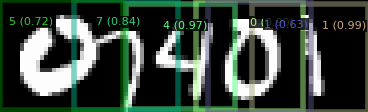

Test_x/image_11.png


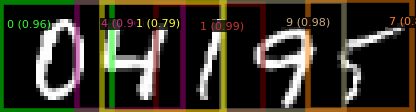

Test_x/image_19.png


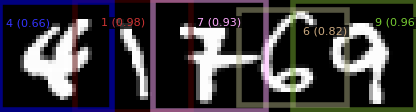

Test_x/image_10.png


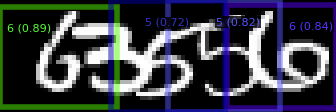

Test_x/image_3.png


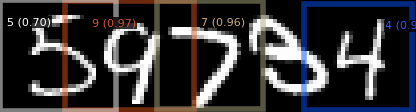

In [8]:
from random import randint
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from random import randint
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

mnist_detection_metadata = MetadataCatalog.get("mnist_detection_test")
for _ in range(5):
    t = randint(1,20)
    print(f"Test_x/image_{str(t)}.png")
    im = cv2.imread(f"Test_x/image_{str(t)}.png")
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()
    classes = instances.pred_classes.numpy()
    v = Visualizer(im[:, :, ::-1],
                   metadata=mnist_detection_metadata,
                   scale=4.0
    )
    # On écrit le label et on dessine le contour pour chaque chiffre
    for i in range(len(boxes)):
        bbox = boxes[i]
        score = scores[i]
        x_center = bbox[0] + bbox[2] / 4
        y_center = bbox[1] + bbox[3] / 6.5
        color = random_color(rgb=True, maximum=1)
        vis = v.draw_box(bbox, edge_color=color)
        vis = v.draw_text(f"{classes[i]} ({score:.2f})", (x_center, y_center), color=color)
        
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
mnist_detection_metadata = MetadataCatalog.get("mnist_detection_test")
mnist_detection_metadata.thing_classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
#On crée une instance de COCOEvaluator pour évaluer la performance du modèle de détection.
evaluator = COCOEvaluator("mnist_detection_test", output_dir="./output")
#On construit un chargeur de données de test pour le modèle.
val_loader = build_detection_test_loader(cfg, "mnist_detection_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [04/10 23:34:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/10 23:34:30 d2.data.datasets.coco]: Loaded 2000 images in COCO format from coco_test.json
[04/10 23:34:30 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    zero    | 980          |    one     | 1135         |    two     | 1032         |
|   three    | 1010         |    four    | 982          |    five    | 892          |
|    six     | 958          |   seven    | 1028         |   eight    | 974          |
|    nine    | 1009         |            |              |            |              |
|   total    | 10000        |            |              |            |              |
[04/10 23:34:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in infe